<a href="https://colab.research.google.com/github/zey-o/DeepLearning_Wikiart_Emotions/blob/main/3_t30_model_20_class_multilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import pathlib
import matplotlib.pyplot as plt

from glob import glob
import os 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Activation
# from keras.callbacks import EarlyStopping
# from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Activation

from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

**The explanation for this model can be found at the beginning of NB 3_t50. Copy& pasting:**


These first 2 model building Notebooks (3_t50 & 3_t30), we try building multi class (20 emotions) multi label models (predicting more than 1 emotion per artwork).

This notebook (3_t50) works with the dataframe/ data from the original study where the authors assign an emotion as having been evoked if it shows up with more than 50% of the annotators. The next NB (3_t30) is one where they assign an emotion as having been evoked if at least 30% of the annotators have marked it as such. This means that there are more emotions marked in the 3_t30 NB.

We see this reflected in the accuracies of the 2 models. The highest accuracy we achieve in this NB is around 25% while with the next NB (3_t30) we do achieve around 5% higher: 30%.

## Check & Load Data from Directory

In [ ]:
dir = 'drive/MyDrive/DL/dataset_images' 

In [ ]:
data_dir = pathlib.Path("drive/MyDrive/DL/dataset_images")

In [ ]:
image_count = len(list(data_dir.glob('**/*.png')))
print(image_count)

4119


In [ ]:
df = pd.read_csv("drive/MyDrive/DL/path_all_30.csv")

In [ ]:
df.head(3)

,ID,Style,Category,Artist,Title,Is painting,Face/body,agreeableness,anger,anticipation,arrogance,disagreeableness,disgust,fear,gratitude,happiness,humility,love,optimism,pessimism,regret,sadness,shame,shyness,surprise,trust,neutral,path
0,58c6237dedc2c9c7dc0de1ae,Modern Art,Impressionism,Charles Courtney Curran,In the Luxembourg Garden,yes,face,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,dataset_images/58c6237dedc2c9c7dc0de1ae.png
1,577280dfedc2cb3880f28e76,Modern Art,Neo-Expressionism,Keith Haring,The Marriage of Heaven and Hell,yes,body,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,dataset_images/577280dfedc2cb3880f28e76.png
2,57727f2dedc2cb3880ed5fa9,Modern Art,Post-Impressionism,Jozsef Rippl-Ronai,Uncle Piacsek in front of the Black Sideboard,yes,face,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,dataset_images/57727f2dedc2cb3880ed5fa9.png


In [ ]:
df.path = "drive/MyDrive/DL/" + df.path
df.head(2)

,ID,Style,Category,Artist,Title,Is painting,Face/body,agreeableness,anger,anticipation,arrogance,disagreeableness,disgust,fear,gratitude,happiness,humility,love,optimism,pessimism,regret,sadness,shame,shyness,surprise,trust,neutral,path
0,58c6237dedc2c9c7dc0de1ae,Modern Art,Impressionism,Charles Courtney Curran,In the Luxembourg Garden,yes,face,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,drive/MyDrive/DL/dataset_images/58c6237dedc2c9...
1,577280dfedc2cb3880f28e76,Modern Art,Neo-Expressionism,Keith Haring,The Marriage of Heaven and Hell,yes,body,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,drive/MyDrive/DL/dataset_images/577280dfedc2cb...
2,57727f2dedc2cb3880ed5fa9,Modern Art,Post-Impressionism,Jozsef Rippl-Ronai,Uncle Piacsek in front of the Black Sideboard,yes,face,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,drive/MyDrive/DL/dataset_images/57727f2dedc2cb...
3,58d1240cedc2c94f900fc610,Modern Art,Cubism,Vadym Meller,Monk. For the Play &#39;Mazeppa&#39;,yes,face,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,drive/MyDrive/DL/dataset_images/58d1240cedc2c9...
4,57727de7edc2cb3880e91f26,Post Renaissance Art,Romanticism,David Wilkie,The Defence of Sarago&#231;a,yes,face,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,drive/MyDrive/DL/dataset_images/57727de7edc2cb...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4100,577287aeedc2cb388007fba9,Modern Art,Color Field Painting,Rupprecht Geiger,OE 260,yes,none,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,drive/MyDrive/DL/dataset_images/577287aeedc2cb...
4101,57728001edc2cb3880efddcf,Modern Art,Surrealism,Oscar Dominguez,M&#225;quina de coser electro-sexual,yes,body,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,drive/MyDrive/DL/dataset_images/57728001edc2cb...
4102,57728ac7edc2cb3880123cc2,Modern Art,Neo-Expressionism,Georg Baselitz,Female Nude on a Kitchen Chair,yes,body,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,drive/MyDrive/DL/dataset_images/57728ac7edc2cb...
4103,57728412edc2cb3880fc9ff4,Modern Art,Expressionism,Marie Laurencin,Apollinaire and His Friends,yes,face,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,drive/MyDrive/DL/dataset_images/57728412edc2cb...


## Modeling 

We will first set the parameters that we will be using throughout the modeling process and then run the following models: 
1. Baseline 
2. Using Convolutions
3. Data Augmentation (with the Convolutions) 
4. A second way of Data Augmentation (implemented with Convolutions) 
5. Transfer Learning 
6. Transfer Learning with Data Augmentation 
7. Transfer Learning with Data Augmentation Getting Rid of Dense Layers but adding more Dropouts as well as regularization in the Layers
8. Transfer Learning + Data Augmentation + Less Complex with more Dropouts + Regularization
9. VGG16 Architecture

The best accuracies were achieved with Models 3 & 8. 

### Set parameters

Let's set some of the parameters we will be using. 

- The image size we will resize all images to at the beginning of our training process. 
- We will set the number of epochs to a certain number so that we can keep tweaking it later. 
- Batch size will be 32. 
- The emotions we will be working with. 
- We will split the data into 3: train - validation - test (60% - 20% - 20%) 

In [ ]:
img_height = 180
img_width = 180

In [ ]:
epochs = 100
batch_size = 32

In [ ]:
emotions = ['agreeableness', 'anger', 'anticipation', 'arrogance',
       'disagreeableness', 'disgust', 'fear', 'gratitude', 'happiness',
       'humility', 'love', 'optimism', 'pessimism', 'regret', 'sadness',
       'shame', 'shyness', 'surprise', 'trust', 'neutral']

In [ ]:
val_set_start = 6*image_count//10
test_set_start = 8*image_count//10

In [ ]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = emotions,
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "raw",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = emotions,
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "raw",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = emotions,
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "raw",
                                            target_size = (img_height, img_width))

Found 2471 validated image filenames.
Found 824 validated image filenames.
Found 810 validated image filenames.


In [ ]:
images, labels = next(train_generator)
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 180, 180, 3)
int64 (32, 20)


In [ ]:
num_classes = labels.shape[1]
num_classes

20

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size


In [ ]:
valid_generator.n

824

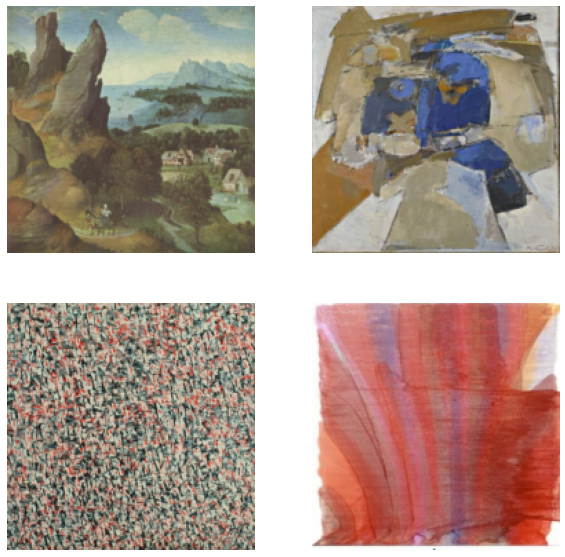

In [ ]:
plt.figure(figsize=(10, 10))

x= train_generator.next()
for i in range(0,4):
    ax = plt.subplot(2, 2, i + 1)
    image = x[0][i]
    plt.imshow(image)
    plt.axis("off")

### 1. Baseline

We will make three generators according to the above split. 

The number of classes will be the number of emotions examined. We know from our EDA that there is a class imbalance between the classses but as we are doing multi-labels we will go with this for now. 

We will then make a baseline model with 20 nodes and plot to see how train & validation accuracy and losses change over epochs. 

In [ ]:
model = Sequential([
    keras.layers.InputLayer(input_shape=(img_height, img_width,3)),
    keras.layers.Dense(units = 20, activation = 'relu'), 
    keras.layers.Flatten(),
    keras.layers.Dense(units = num_classes, activation = 'sigmoid') 
])

In [ ]:
model.compile(optimizer='adam',loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 180, 180, 20)      80        
_________________________________________________________________
flatten_5 (Flatten)          (None, 648000)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 14)                9072014   
Total params: 9,072,094
Trainable params: 9,072,094
Non-trainable params: 0
_________________________________________________________________


We will use Early Stopping because we know from earlier tries that this model does overfit. 

In [ ]:
history_baseline = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 8,\
                                             restore_best_weights=True)
)

Epoch 1/100
77/77 [==============================] - 117s 1s/step - loss: 1.3144 - accuracy: 0.1349 - val_loss: 0.4692 - val_accuracy: 0.1325
Epoch 2/100
77/77 [==============================] - 103s 1s/step - loss: 0.2794 - accuracy: 0.2107 - val_loss: 0.2831 - val_accuracy: 0.1213
Epoch 3/100
77/77 [==============================] - 96s 1s/step - loss: 0.1863 - accuracy: 0.2509 - val_loss: 0.2510 - val_accuracy: 0.1950
Epoch 4/100
77/77 [==============================] - 95s 1s/step - loss: 0.1529 - accuracy: 0.3026 - val_loss: 0.2576 - val_accuracy: 0.1363
Epoch 5/100
77/77 [==============================] - 95s 1s/step - loss: 0.1238 - accuracy: 0.3415 - val_loss: 0.2951 - val_accuracy: 0.1637
Epoch 6/100
77/77 [==============================] - 107s 1s/step - loss: 0.0997 - accuracy: 0.3756 - val_loss: 0.2630 - val_accuracy: 0.1988
Epoch 7/100
77/77 [==============================] - 99s 1s/step - loss: 0.0859 - accuracy: 0.4071 - val_loss: 0.2805 - val_accuracy: 0.1475
Epoch 8/10

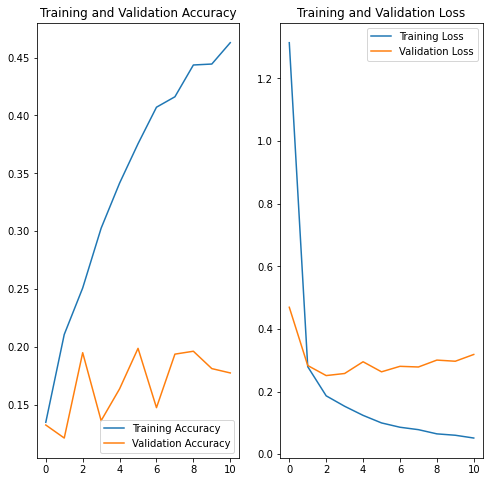

In [ ]:
number_of_epochs_it_ran = len(history_baseline.history['loss'])

acc = history_baseline.history['accuracy']
val_acc = history_baseline.history['val_accuracy']

loss = history_baseline.history['loss']
val_loss = history_baseline.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 2. Using Convolutions

Let's first try making our own convolutions. 

In [ ]:
model = Sequential()


model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(img_height, img_width,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 89, 89, 32)        0         
                                                        

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [ ]:
history_cnn = model.fit(train_generator,
                    # steps_per_epoch=STEP_SIZE_TRAIN,
                    steps_per_epoch = 25, 
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 20,\
                                             restore_best_weights=True)
)

Epoch 1/100
25/25 [==============================] - 382s 16s/step - loss: 0.2683 - accuracy: 0.2181 - val_loss: 0.2705 - val_accuracy: 0.2637
Epoch 2/100
25/25 [==============================] - 75s 3s/step - loss: 0.2611 - accuracy: 0.2387 - val_loss: 0.2975 - val_accuracy: 0.2775
Epoch 3/100
25/25 [==============================] - 63s 3s/step - loss: 0.2630 - accuracy: 0.2488 - val_loss: 0.2672 - val_accuracy: 0.2512
Epoch 4/100
25/25 [==============================] - 58s 2s/step - loss: 0.2609 - accuracy: 0.2025 - val_loss: 0.2690 - val_accuracy: 0.2313
Epoch 5/100
25/25 [==============================] - 49s 2s/step - loss: 0.2559 - accuracy: 0.2271 - val_loss: 0.2730 - val_accuracy: 0.2237
Epoch 6/100
25/25 [==============================] - 45s 2s/step - loss: 0.2539 - accuracy: 0.2200 - val_loss: 0.2740 - val_accuracy: 0.2738
Epoch 7/100
25/25 [==============================] - 43s 2s/step - loss: 0.2529 - accuracy: 0.2800 - val_loss: 0.2643 - val_accuracy: 0.2275
Epoch 8/100

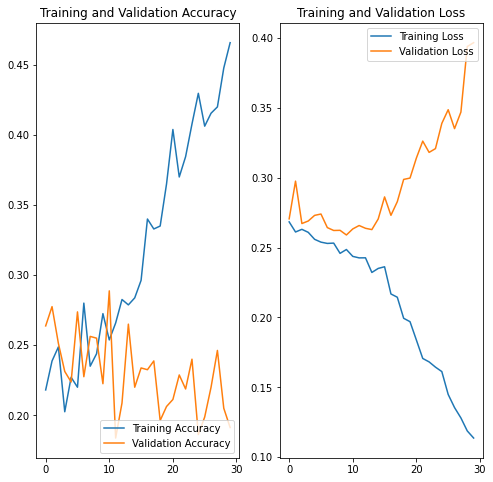

In [ ]:
number_of_epochs_it_ran = len(history_cnn.history['loss'])

acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']

loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 3. Data Augmentation

Now let's try the same convolutions we looked at but do it with augmented data. 

In [ ]:
train_generator.reset()
valid_generator.reset()
test_generator.reset()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

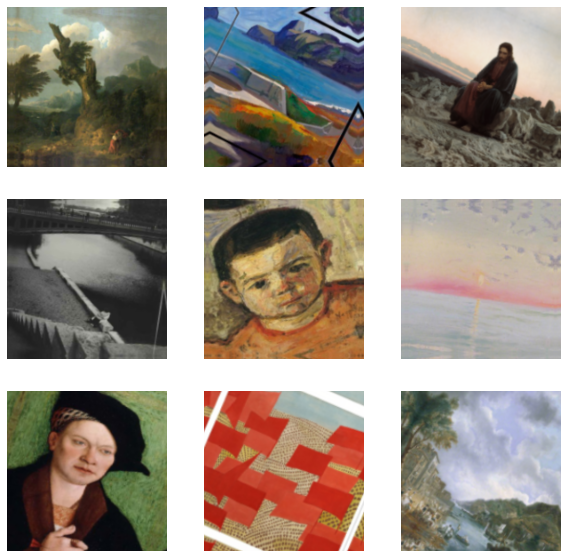

In [ ]:
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)
augmented_images = data_augmentation(images)

for i in range(0, 9): 
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_images[i])
  plt.axis("off")


In [ ]:
model = Sequential([
    data_augmentation, 
    layers.Conv2D(32, (3, 3), padding='same', activation = 'relu'), 
    layers.Conv2D(64, (3, 3), padding='same', activation = 'relu'), 
    layers.MaxPooling2D(pool_size=(2, 2)), 
    layers.Dropout(0.25), 
    layers.Conv2D(64, (3, 3), padding='same', activation = 'relu'), 
    layers.Conv2D(64, (3, 3), padding='same', activation = 'relu'), 
    layers.MaxPooling2D(pool_size=(2, 2)), 
    layers.Dropout(0.25), 
    layers.Flatten(),
    layers.Dense(512, activation = 'relu'), 
    layers.Dropout(0.5), 
    layers.Dense(num_classes, activation='sigmoid')])

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 90, 90, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 64)        36928     
                                                      

In [ ]:
history_aug = model.fit(train_generator,
                    # steps_per_epoch=STEP_SIZE_TRAIN,
                    steps_per_epoch = 25, 
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 20,\
                                             restore_best_weights=True)
)

Epoch 1/100
25/25 [==============================] - 40s 2s/step - loss: 0.3993 - accuracy: 0.1838 - val_loss: 0.2848 - val_accuracy: 0.3050
Epoch 2/100
25/25 [==============================] - 40s 2s/step - loss: 0.2835 - accuracy: 0.2632 - val_loss: 0.2753 - val_accuracy: 0.2525
Epoch 3/100
25/25 [==============================] - 37s 2s/step - loss: 0.2666 - accuracy: 0.2412 - val_loss: 0.2748 - val_accuracy: 0.2412
Epoch 4/100
25/25 [==============================] - 39s 2s/step - loss: 0.2668 - accuracy: 0.2412 - val_loss: 0.2744 - val_accuracy: 0.1637
Epoch 5/100
25/25 [==============================] - 38s 2s/step - loss: 0.2612 - accuracy: 0.2090 - val_loss: 0.2742 - val_accuracy: 0.2512
Epoch 6/100
25/25 [==============================] - 40s 2s/step - loss: 0.2574 - accuracy: 0.2529 - val_loss: 0.2692 - val_accuracy: 0.2113
Epoch 7/100
25/25 [==============================] - 37s 2s/step - loss: 0.2542 - accuracy: 0.2245 - val_loss: 0.2663 - val_accuracy: 0.2275
Epoch 8/100
2

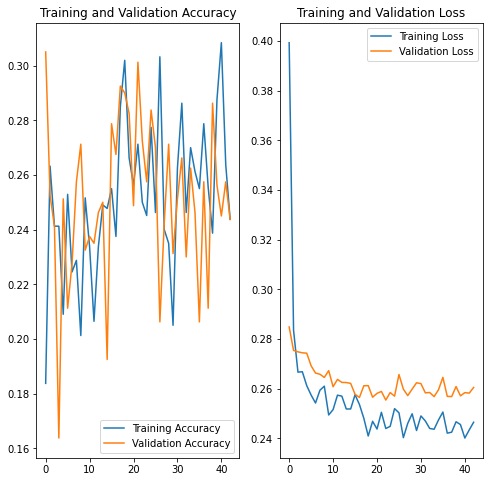

In [ ]:
number_of_epochs_it_ran = len(history_aug.history['loss'])

acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']

loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 4. Second Way: Data Augmentation

A second way of data augmentation. Data augmentation is important as we are overfitting badly so we have to figure out ways to deal with this. 

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = emotions,
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "raw",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = emotions,
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "raw",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = emotions,
                                            batch_size = 32,
                                            interpolation = 'bilinear',    
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "raw",
                                            target_size = (img_height, img_width))

Found 2471 validated image filenames.
Found 824 validated image filenames.
Found 810 validated image filenames.


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(img_height, img_width,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 activation_5 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_6 (Activation)   (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 89, 89, 32)        0         
                                                      

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [ ]:
history_aug2 = model.fit(train_generator,
                    # steps_per_epoch=STEP_SIZE_TRAIN,
                    steps_per_epoch = 25, 
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs, 
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 8\
                                            #  , restore_best_weights=True
))

Epoch 1/100
25/25 [==============================] - 45s 2s/step - loss: 0.3436 - accuracy: 0.1535 - val_loss: 0.3036 - val_accuracy: 0.1925
Epoch 2/100
25/25 [==============================] - 45s 2s/step - loss: 0.2806 - accuracy: 0.2275 - val_loss: 0.2650 - val_accuracy: 0.2788
Epoch 3/100
25/25 [==============================] - 44s 2s/step - loss: 0.2686 - accuracy: 0.1975 - val_loss: 0.2667 - val_accuracy: 0.2025
Epoch 4/100
25/25 [==============================] - 43s 2s/step - loss: 0.2635 - accuracy: 0.2181 - val_loss: 0.2749 - val_accuracy: 0.2763
Epoch 5/100
25/25 [==============================] - 44s 2s/step - loss: 0.2704 - accuracy: 0.2313 - val_loss: 0.2639 - val_accuracy: 0.3025
Epoch 6/100
25/25 [==============================] - 43s 2s/step - loss: 0.2589 - accuracy: 0.2310 - val_loss: 0.2646 - val_accuracy: 0.2463
Epoch 7/100
25/25 [==============================] - 43s 2s/step - loss: 0.2630 - accuracy: 0.2013 - val_loss: 0.2663 - val_accuracy: 0.2475
Epoch 8/100
2

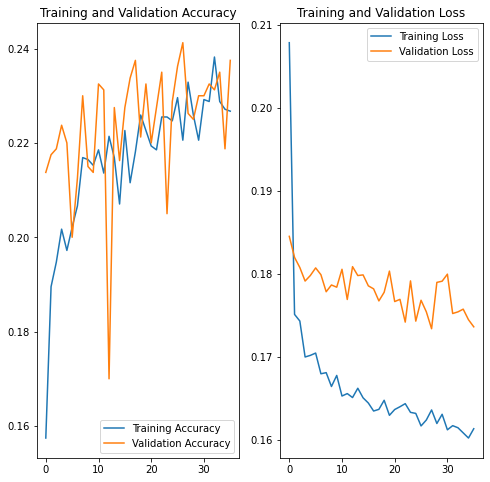

In [ ]:
number_of_epochs_it_ran = len(history_aug2.history['loss'])

acc = history_aug2.history['accuracy']
val_acc = history_aug2.history['val_accuracy']

loss = history_aug2.history['loss']
val_loss = history_aug2.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 5. Transfer Learning

OK maybe our own convolutions are not working for us. Let's borrow from the giants. \
MobileNetV2 is what we will resort to first. 

In [ ]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = emotions,
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "raw",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = emotions,
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "raw",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = emotions,
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "raw",
                                            target_size = (img_height, img_width))

Found 2471 validated image filenames.
Found 824 validated image filenames.
Found 810 validated image filenames.


In [ ]:
base_model = mobilenet_v2.MobileNetV2\
                (weights='imagenet', include_top=False, input_shape=(img_height, img_width,3)) 

for layer in base_model.layers:
    layer.trainable = False   


9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
x = base_model.output
x = Flatten()(x) 
x = Dense(512, activation='relu')(x) 
x = Dense(50, activation='relu')(x)
predictions = Dense(num_classes, activation='sigmoid')(x) 

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][0]']           

In [ ]:
history_transfer = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 8,\
                                             restore_best_weights=True)
)

Epoch 1/100
77/77 [==============================] - 83s 1s/step - loss: 0.8923 - accuracy: 0.2181 - val_loss: 0.4773 - val_accuracy: 0.2663
Epoch 2/100
77/77 [==============================] - 79s 1s/step - loss: 0.3074 - accuracy: 0.3600 - val_loss: 0.4355 - val_accuracy: 0.1775
Epoch 3/100
77/77 [==============================] - 79s 1s/step - loss: 0.2107 - accuracy: 0.4149 - val_loss: 0.3656 - val_accuracy: 0.2625
Epoch 4/100
77/77 [==============================] - 79s 1s/step - loss: 0.1452 - accuracy: 0.4879 - val_loss: 0.3802 - val_accuracy: 0.3013
Epoch 5/100
77/77 [==============================] - 80s 1s/step - loss: 0.1154 - accuracy: 0.5390 - val_loss: 0.3922 - val_accuracy: 0.2700
Epoch 6/100
77/77 [==============================] - 79s 1s/step - loss: 0.0972 - accuracy: 0.5314 - val_loss: 0.4057 - val_accuracy: 0.3237
Epoch 7/100
77/77 [==============================] - 79s 1s/step - loss: 0.0845 - accuracy: 0.5506 - val_loss: 0.4483 - val_accuracy: 0.2862
Epoch 8/100
7

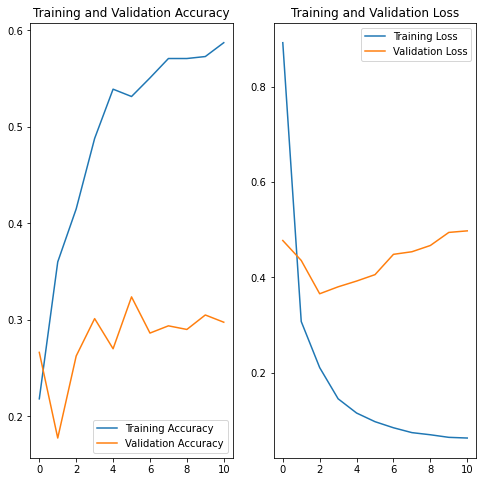

In [ ]:
number_of_epochs_it_ran = len(history_transfer.history['loss'])

acc = history_transfer.history['accuracy']
val_acc = history_transfer.history['val_accuracy']

loss = history_transfer.history['loss']
val_loss = history_transfer.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Still overfitting out of this world. 

### 6. Transfer Learning with Data Augmentation

OK, one more resort: try transfer with augmented data. 

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = emotions,
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "raw",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = emotions,
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "raw",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = emotions,
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "raw",
                                            target_size = (img_height, img_width))

Found 2471 validated image filenames.
Found 824 validated image filenames.
Found 810 validated image filenames.


In [ ]:
base_model = mobilenet_v2.MobileNetV2\
                (weights='imagenet', include_top=False, input_shape=(img_height, img_width,3)) 

for layer in base_model.layers:
    layer.trainable = False   


In [ ]:
# Establish new fully connected block
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(512, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(50, activation='relu')(x)
predictions = Dense(num_classes, activation='sigmoid')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 90, 90, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 90, 90, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 90, 90, 32)   0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
history_transfer_aug = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 8,\
                                             restore_best_weights=True)
)

Epoch 1/100
77/77 [==============================] - 180s 2s/step - loss: 0.1842 - accuracy: 0.2645 - val_loss: 0.2474 - val_accuracy: 0.2125
Epoch 2/100
77/77 [==============================] - 167s 2s/step - loss: 0.1822 - accuracy: 0.2739 - val_loss: 0.2440 - val_accuracy: 0.1688
Epoch 3/100
77/77 [==============================] - 155s 2s/step - loss: 0.1741 - accuracy: 0.2702 - val_loss: 0.2521 - val_accuracy: 0.2525
Epoch 4/100
77/77 [==============================] - 154s 2s/step - loss: 0.1674 - accuracy: 0.2759 - val_loss: 0.2183 - val_accuracy: 0.2400
Epoch 5/100
77/77 [==============================] - 169s 2s/step - loss: 0.1582 - accuracy: 0.2845 - val_loss: 0.2332 - val_accuracy: 0.2450
Epoch 6/100
77/77 [==============================] - 169s 2s/step - loss: 0.1471 - accuracy: 0.3001 - val_loss: 0.2552 - val_accuracy: 0.2212
Epoch 7/100
77/77 [==============================] - 169s 2s/step - loss: 0.1676 - accuracy: 0.2854 - val_loss: 0.2283 - val_accuracy: 0.2275
Epoch 

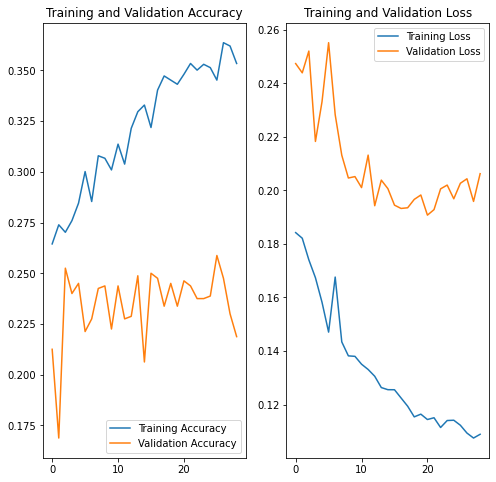

In [ ]:
number_of_epochs_it_ran = len(history_transfer_aug.history['loss'])

acc = history_transfer_aug.history['accuracy']
val_acc = history_transfer_aug.history['val_accuracy']

loss = history_transfer_aug.history['loss']
val_loss = history_transfer_aug.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 7. Transfer Learning + Data Augmentation + Less Complex with more Dropouts + Regularization

Make it less complex and try more dropouts. 

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = emotions,
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "raw",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = emotions,
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "raw",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = emotions,
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "raw",
                                            target_size = (img_height, img_width))

Found 2471 validated image filenames.
Found 824 validated image filenames.
Found 810 validated image filenames.


In [ ]:
train_generator.next()[1].shape

(32, 20)

In [ ]:
base_model = mobilenet_v2.MobileNetV2\
                (weights='imagenet', include_top=False, input_shape=(img_height, img_width,3)) 

for layer in base_model.layers:
    layer.trainable = False   


In [ ]:
L2 = 50
DROP = 0.3

x = base_model.output
x = Flatten()(x) 
x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x) 
x = Dropout(DROP)(x)
x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x)
x = Dropout(DROP)(x)
predictions = Dense(num_classes, activation='sigmoid')(x) 


model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

#NOT TRYING THIS OUT NOW BUT NEXT STEP WILL BE SETTING LR EVEN SMALLER
#model.compile(keras.optimizers.Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_6[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][0]']         

In [ ]:
lr = (ReduceLROnPlateau(factor=.5, patience=3, verbose=1))
es = (EarlyStopping(verbose=1, patience = 8, restore_best_weights=True))

history_transfer_aug_drop = model.fit(train_generator,
                    # steps_per_epoch=STEP_SIZE_TRAIN,
                    steps_per_epoch = 25, 
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs, 
                    callbacks = [es, lr]
)


# TAKING OUT THE FOLLOWING FROM LAST MODEL IN EARLYSTOPPING: 
# monitor='val_loss', mode='min', 

Epoch 1/100
25/25 [==============================] - 48s 2s/step - loss: 3025.9133 - accuracy: 0.0852 - val_loss: 1955.3157 - val_accuracy: 0.0575 - lr: 0.0010
Epoch 2/100
25/25 [==============================] - 44s 2s/step - loss: 1611.1082 - accuracy: 0.0938 - val_loss: 1322.8871 - val_accuracy: 0.0562 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - 43s 2s/step - loss: 1126.3937 - accuracy: 0.1535 - val_loss: 935.0055 - val_accuracy: 0.3038 - lr: 0.0010
Epoch 4/100
25/25 [==============================] - 44s 2s/step - loss: 793.3770 - accuracy: 0.1700 - val_loss: 655.7283 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 5/100
25/25 [==============================] - 45s 2s/step - loss: 551.5293 - accuracy: 0.1794 - val_loss: 454.5594 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 6/100
25/25 [==============================] - 42s 2s/step - loss: 381.5270 - accuracy: 0.1887 - val_loss: 310.9319 - val_accuracy: 0.3088 - lr: 0.0010
Epoch 7/100
25/25 [============================

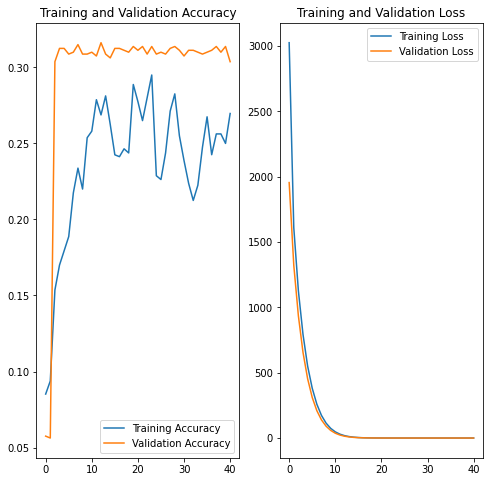

In [ ]:
number_of_epochs_it_ran = len(history_transfer_aug_drop.history['loss'])

acc = history_transfer_aug_drop.history['accuracy']
val_acc = history_transfer_aug_drop.history['val_accuracy']

loss = history_transfer_aug_drop.history['loss']
val_loss = history_transfer_aug_drop.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 8. Transfer Learning + Data Augmentation + Less Complex with more Dropouts + Regularization


Make it less complex and try more dropouts. 

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = emotions,
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "raw",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = emotions,
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "raw",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = emotions,
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "raw",
                                            target_size = (img_height, img_width))

Found 2471 validated image filenames.
Found 824 validated image filenames.
Found 810 validated image filenames.


In [ ]:
base_model = mobilenet_v2.MobileNetV2\
                (weights='imagenet', include_top=False, input_shape=(img_height, img_width,3)) 

for layer in base_model.layers:
    layer.trainable = False   

In [ ]:
L2 = 50
DROP = 0.3

x = base_model.output
x = Flatten()(x) 
x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x) 
x = Dropout(DROP)(x)
x = Dense(200, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x)
x = Dropout(DROP)(x)
x = Dense(300, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x)
x = Dropout(DROP)(x)
x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x)
x = Dropout(DROP)(x)
x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x) 
x = Dropout(DROP)(x)
predictions = Dense(num_classes, activation='sigmoid')(x) 


model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_5[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][0]']         

In [ ]:
lr = (ReduceLROnPlateau(factor=.5, patience=3, verbose=1))
es = (EarlyStopping(verbose=1, patience = 8, restore_best_weights=True))

history_transfer_aug_drop = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs, 
                    callbacks = [es, lr]
)


# TAKING OUT THE FOLLOWING FROM LAST MODEL IN EARLYSTOPPING: 
# monitor='val_loss', mode='min', 

Epoch 1/100
77/77 [==============================] - 99s 1s/step - loss: 10401.5322 - accuracy: 0.1148 - val_loss: 3017.1406 - val_accuracy: 0.0300 - lr: 0.0010
Epoch 2/100
77/77 [==============================] - 96s 1s/step - loss: 1324.1965 - accuracy: 0.1554 - val_loss: 441.0656 - val_accuracy: 0.3100 - lr: 0.0010
Epoch 3/100
77/77 [==============================] - 95s 1s/step - loss: 216.7628 - accuracy: 0.2673 - val_loss: 89.4766 - val_accuracy: 0.3038 - lr: 0.0010
Epoch 4/100
77/77 [==============================] - 95s 1s/step - loss: 46.7500 - accuracy: 0.2780 - val_loss: 19.8471 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 5/100
77/77 [==============================] - 94s 1s/step - loss: 10.1663 - accuracy: 0.2813 - val_loss: 4.1881 - val_accuracy: 0.3137 - lr: 0.0010
Epoch 6/100
77/77 [==============================] - 95s 1s/step - loss: 2.1657 - accuracy: 0.2575 - val_loss: 0.9470 - val_accuracy: 0.3113 - lr: 0.0010
Epoch 7/100
77/77 [==============================] - 95s 1

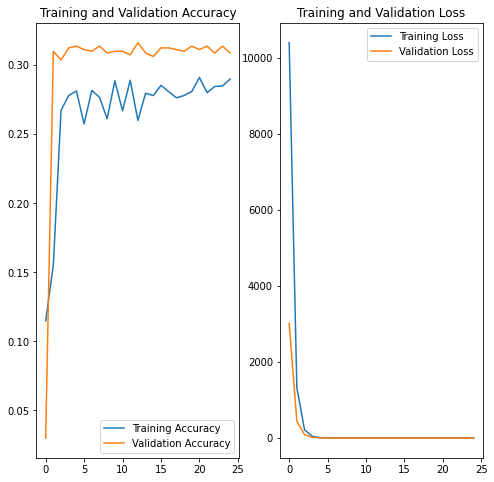

In [ ]:
number_of_epochs_it_ran = len(history_transfer_aug_drop.history['loss'])

acc = history_transfer_aug_drop.history['accuracy']
val_acc = history_transfer_aug_drop.history['val_accuracy']

loss = history_transfer_aug_drop.history['loss']
val_loss = history_transfer_aug_drop.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 9. Try VGG16  

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import InputLayer

In [ ]:
L2 = 50
DROP = 0.3

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = emotions,
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "raw",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = emotions,
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = True,
                                            class_mode = "raw",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = emotions,
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = True,
                                            class_mode = "raw",
                                            target_size = (img_height, img_width))

Found 2471 validated image filenames.
Found 824 validated image filenames.
Found 810 validated image filenames.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width,3)) 

for layer in base_model.layers:
    layer.trainable = False   

In [ ]:
# x = base_model.output
# x = Flatten()(x) 
# x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x) 
# x = Dropout(DROP)(x)
# x = Dense(200, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x)
# x = Dropout(DROP)(x)
# x = Dense(300, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x)
# x = Dropout(DROP)(x)
# x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x)
# x = Dropout(DROP)(x)
# x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x) 
# x = Dropout(DROP)(x)
# predictions = Dense(num_classes, activation='sigmoid')(x) 

# model = Model(inputs=base_model.input, outputs=predictions)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model = Sequential(
                [InputLayer(input_shape= (img_height, img_width, 3)),
                 base_model,
                 Flatten(),
                 Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l2(L2)),
                 Dropout(DROP), 
                 Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l2(L2)),
                 Dropout(DROP), 
                 Dense(num_classes, activation='sigmoid')]
               )

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True)

In [ ]:
lr = (ReduceLROnPlateau(factor=.5, patience=3, verbose=1))
es = (EarlyStopping(verbose=1, patience = 8, restore_best_weights=True, monitor='val_loss'))



In [ ]:
history_vgg_model = model.fit(train_generator,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=valid_generator,
                      validation_steps=STEP_SIZE_VALID,
                      epochs=epochs,
                      callbacks = [es, lr])

Epoch 1/100
77/77 [==============================] - 2223s 29s/step - loss: 3478.8372 - accuracy: 0.2153 - val_loss: 1098.3134 - val_accuracy: 0.3075 - lr: 0.0010
Epoch 2/100
77/77 [==============================] - 153s 2s/step - loss: 529.8077 - accuracy: 0.2985 - val_loss: 184.9594 - val_accuracy: 0.3100 - lr: 0.0010
Epoch 3/100
77/77 [==============================] - 164s 2s/step - loss: 81.0035 - accuracy: 0.2956 - val_loss: 23.0753 - val_accuracy: 0.3038 - lr: 0.0010
Epoch 4/100
77/77 [==============================] - 164s 2s/step - loss: 9.2055 - accuracy: 0.2825 - val_loss: 2.2735 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 5/100
77/77 [==============================] - 152s 2s/step - loss: 0.9730 - accuracy: 0.2739 - val_loss: 0.3955 - val_accuracy: 0.3137 - lr: 0.0010
Epoch 6/100
77/77 [==============================] - 163s 2s/step - loss: 0.3042 - accuracy: 0.2747 - val_loss: 0.2782 - val_accuracy: 0.3113 - lr: 0.0010
Epoch 7/100
77/77 [==============================] - 151

In [ ]:
model.save('multiclass_vgg16_model.h5')

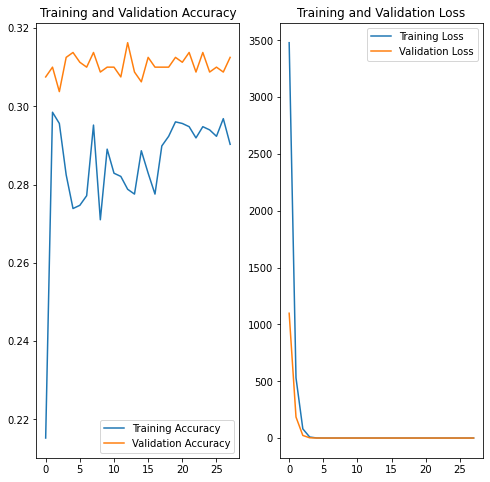

In [ ]:
number_of_epochs_it_ran = len(history_vgg_model.history['loss'])

acc = history_vgg_model.history['accuracy']
val_acc = history_vgg_model.history['val_accuracy']

loss = history_vgg_model.history['loss']
val_loss = history_vgg_model.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predict

In [ ]:
model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_TEST)

In [ ]:
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

Top emotion

In [ ]:
predicted_class_indices=np.argmax(pred,axis=1)

In [ ]:
predictions = [emotions[k] for k in predicted_class_indices]
predictions

Top 3 emotions

In [ ]:
predicted_classes_indices = (np.argsort(pred)[:, :3])
predicted_classes_indices

In [ ]:
predictions_top_3 = [[emotions[k] for k in row] for row in predicted_classes_indices]
predictions_top_3 

In [ ]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

Test an image for one emotion

In [ ]:
orozco_path = "best_artworks_images/1024px-Orozco_Mural_Omniciencia_1925_Azulejos.jpg"

img = tf.keras.utils.load_img(
    orozco_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely evokes {} with a {:.2f} percent confidence."
    .format(emotions[np.argmax(score)], 100 * np.max(score))
)